# Convolutional neural network with TensorFlow 2

In [ ]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import skimage.transform
import tensorflow as tf
from cnn_utils import *

%matplotlib inline
np.random.seed(4)

2021-11-17 00:12:06.082283: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0



## - The SIGN dataset

Load the "SIGNS" dataset.

- `X_train` is the dataset used to train the model. 
- `X_test` is the dataset to test the performance of the trained model.


In [ ]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

The SIGNS dataset is a collection of 6 signs representing numbers from 0 to 5.

<img src="/images/SIGNS.png" style="width:800px;height:300px;">

The next cell will show you an example of a labelled image in the dataset. 

y = 2


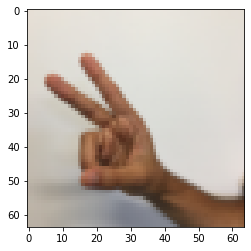

In [ ]:
# Example of a picture
index = 6
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

To get started, let's examine the shapes of the data. 

In [ ]:
print ("number of training examples = " + str(X_train_orig.shape[0]))
print ("number of test examples = " + str(X_test_orig.shape[0]))
print ("X_train shape: " + str(X_train_orig.shape))
print ("Y_train shape: " + str(Y_train_orig.shape))
print ("X_test shape: " + str(X_test_orig.shape))
print ("Y_test shape: " + str(Y_test_orig.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1, 1080)
X_test shape: (120, 64, 64, 3)
Y_test shape: (1, 120)


Pixels in each channel (RGB) of the images take values in the range \[0, 255\]. However, it is desirable to have absolute values in the range \[0, 1\] as input for neural networks architectures to avoid exploding gradient problems. Through the following cell, we apply a simple data scaling procedure: we divide the values of the pixels by 255.

In [ ]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.

With the following cell we convert the labels into one-hot vectors. Note that this is not the only way to provide this information to the training method of TensorFlow. The other possibility is to pass directly the labels instead of their one-hot representation. We will see the latter approach in the second part of the notebook. What is important is to change the loss function accordingly. 

In [ ]:
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

## 2 - TensorFlow model

### 2.1 - Model definition

We use the TensorFlow built-in functions that carry out the convolution steps for us.

- **`tf.keras.layers.Conv2D(filters, kernel_size, strides, padding, activation)`:** You can read the full documentation [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)


- **`tf.keras.layers.MaxPool2D(pool_size, strides, padding)`:** You can read the full documentation [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)

- **`tf.keras.layers.flatten()`**: You can read the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten)


- **`tf.keras.layers.Dense(units, activation)`:** You can read the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)


Implement the model! There are two ways to do that in TensorFlow (see [here](https://www.tensorflow.org/api_docs/python/tf/keras/models)).We will use the `Sequential` class. 

Use **tf.keras.Sequential([layer1, layer2, ...])** to build the model. 
```python
network_model = tf.keras.Sequential([tf.keras.layers.Conv2D(8, (3, 3), strides=(1,1), padding='same', activation=None), tf.keras.layers.BatchNormalization(axis=-1), ..., ...])
```

Full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)

In [ ]:
# NETWORK MODEL

network_model = tf.keras.Sequential([tf.keras.layers.Conv2D(4, (3, 3), strides=(1,1), padding='same', activation=None),
                                   tf.keras.layers.BatchNormalization(axis=-1),
                                   tf.keras.layers.Activation('relu'),
                                     
                                   tf.keras.layers.MaxPool2D((2, 2), strides=(2, 2), padding='same'),
                                       
                                   tf.keras.layers.Conv2D(8, (3, 3), strides=(1,1), padding='same', activation=None),
                                   tf.keras.layers.BatchNormalization(axis=-1),
                                   tf.keras.layers.Activation('relu'),
                                       
                                   tf.keras.layers.MaxPool2D((2, 2), strides=(2, 2), padding='same'),
                                       
                                   tf.keras.layers.Flatten(),
                                   tf.keras.layers.Dense(16, activation='relu'),
                                   tf.keras.layers.Dense(6, activation=None)])


2021-11-17 00:12:11.587391: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-17 00:12:11.587960: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-17 00:12:11.619181: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-17 00:12:11.619568: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1070 computeCapability: 6.1
coreClock: 1.683GHz coreCount: 15 deviceMemorySize: 7.93GiB deviceMemoryBandwidth: 238.66GiB/s
2021-11-17 00:12:11.619588: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-11-17 00:12:11.621103: I tensorflow/stream_executor/platform/default/d

Test your model: forward propagate random numbers.

In [ ]:
tf.random.set_seed(1)
X = tf.random.normal((2, 64, 64, 3), dtype=tf.dtypes.float32)

outp = network_model(X, training=True)

print("outp = " + str(outp))

2021-11-17 00:12:13.579411: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


outp = tf.Tensor(
[[-0.29602325 -3.3615775  -1.4559786   0.3957122   1.804526   -0.9577934 ]
 [-0.23006228 -2.7567248  -1.5753794   0.7681395   2.5406003  -0.9202403 ]], shape=(2, 6), dtype=float32)


2021-11-17 00:12:14.182912: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-11-17 00:12:14.328060: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


**Expected Output with the suggested network**:

<table> 
    <td> 
    outp =
    </td>
    <td>
    [[ -0.29602313 -3.361574   -1.4559761   0.39570943  1.8045243  -0.9577948  ] <br>
 [ -0.2300619  -2.7567208  -1.5753769   0.7681382   2.5406008  -0.920241 ]]
    </td>
</table>

**NOTE** If there are layers with different behavior during training versus inference (e.g. Dropout), you should write
```python
outp = network_model(X, training=True)
```

### 2.2 - Compute cost

Implement below the function to compute the cost. For that, you need to combine the following two functions: 

- **`tf.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=True)`:** computes the softmax entropy loss. This function both computes the `softmax` activation function as well as the resulting loss. You can check the full documentation  [here.](https://www.tensorflow.org/api_docs/python/tf/keras/losses/categorical_crossentropy)
Pay attention to the `from_logit` argument. The default value is `from_logits=False` which assumes that y_pred contains probabilities (i.e., the `softmax` activation was already applied to the output layer).
Instead, the computation of the loss starting from the logits can be helpful with numerical stability. For that, we need to use `from_logits=True` and remember not to apply the softmax to the output of the network.

- **`tf.reduce_mean`:** computes the mean of elements across dimensions of a tensor. Use this to sum the losses over all the examples to get the overall cost. You can check the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/reduce_mean)

**Exercise**: Compute the cost below using the function above.

In [ ]:
# FUNCTION: compute_cost 

def compute_cost(outp, Y):
    """
    Computes the cost
    
    Arguments:
    outp -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as outp
    
    Returns:
    cost - Tensor of the cost function
    """
   
    cost = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_pred= outp, y_true = Y, from_logits=True))
  
    return cost

In [ ]:
tf.random.set_seed(1)
X = tf.random.normal((2, 64, 64, 3), dtype=tf.dtypes.float32)
Y = tf.random.normal((2,6), dtype=tf.dtypes.float32)

outp = network_model(X, training=True)
cost = compute_cost(outp, Y)

print("cost = " + str(cost))

cost = tf.Tensor(-12.115368, shape=(), dtype=float32)


**Expected Output with the suggested network**: 

<table>
    <td> 
    cost =
    </td>
    <td> 
    -12.115362
    </td> 
</table>

### 2.3 - Train the network by implementing our own training pipeline


In [ ]:
# FUNCTION: model

def train_model(network_model, X_train, Y_train, X_test, Y_test, learning_rate = 0.005,
          num_epochs = 300, minibatch_size = 64, print_cost = True):
    """
    Train a ConvNet in TensorFlow
    
    Arguments:
    network_model -- the keras Sequential model to be trained
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- training set, of shape (None, n_y = 6)
    X_test -- test set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    validation_accuracy -- real number, testing accuracy on the validation set (X_val)
    """
    
    tf.random.set_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    
    optimizer = tf.keras.optimizers.Adam(learning_rate)


    # Do the training loop
    for epoch in range(num_epochs):

        minibatch_cost = 0.
        num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
        seed += 1
        minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

        for minibatch in minibatches:
            with tf.GradientTape() as tape:
                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch

                # Forward propagation
               
                outp = network_model(minibatch_X, training=True)
                

                # Cost function
                
                cost = compute_cost(outp, minibatch_Y)
               
                
            # Compute the gradient

            gradients = tape.gradient(cost, network_model.trainable_variables)
            
            
            # Apply the optimizer
        
            optimizer.apply_gradients(zip(gradients, network_model.trainable_variables))
        

            minibatch_cost += cost / num_minibatches

        # Print the cost every epoch
        if print_cost == True and epoch % 5 == 0:
            print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
        if print_cost == True and epoch % 1 == 0:
            costs.append(minibatch_cost)

    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    # Calculate accuracy on the validation set
    train_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(network_model(X_train, training=False), 1), tf.argmax(Y_train, 1)), "float"))
    test_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(network_model(X_test, training=False), 1), tf.argmax(Y_test, 1)), "float"))

    print("Train Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)

    return train_accuracy, test_accuracy, network_model

Now it's time to use the above function and train the convolutional neural network.

TensorFlow requires as input `tf.float32` values.

In [ ]:
X_train_cast = X_train.astype(dtype=np.float32)
X_test_cast = X_test.astype(dtype=np.float32)

Run the following cell to train the model for 50 epochs.

Cost after epoch 0: 1.707023
Cost after epoch 5: 0.590479
Cost after epoch 10: 0.172335
Cost after epoch 15: 0.031642
Cost after epoch 20: 0.014902
Cost after epoch 25: 0.010188
Cost after epoch 30: 0.006953
Cost after epoch 35: 0.007895
Cost after epoch 40: 0.003337
Cost after epoch 45: 0.002291


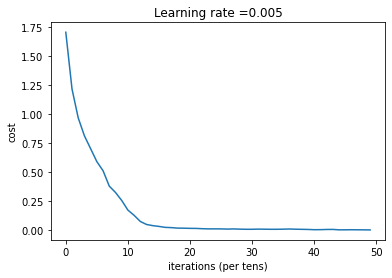

Train Accuracy: tf.Tensor(0.99814814, shape=(), dtype=float32)
Test Accuracy: tf.Tensor(0.89166665, shape=(), dtype=float32)


In [ ]:
_, _, network_model_trained = train_model(network_model, X_train_cast, Y_train, X_test_cast, Y_test, num_epochs=50)